In [1]:
import gzip
import shutil
import os
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import cv2

In [2]:
def extractNcFiles(srcDir, destDir):
    '''
    extract all nc files to destDir folder
    '''
    if not os.path.exists(destDir):
        os.mkdir(destDir)
    counter = 0
    for fn in os.listdir(srcDir):
        if fn[-6:] == '.nc.gz':
            name = fn.split('.')[0]
            with gzip.open(os.path.join(srcDir, fn), 'rb') as f_in:
                with open(os.path.join(destDir, name+'.nc'), 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
                    counter += 1
                    if counter % 500 == 0:
                        print('{} files extracted'.format(counter))
    print("{} nc files extracted in total".format(counter))

def normalize(img):
    '''
    normalize the pixel values to range [0, 255]
    '''
    norm = (img - img.min())*255/(img.max() - img.min())
    return norm.astype(int)

def get_date(fpath):
    '''
    extract the date from file path
    '''
    date = fpath.split('/')[-1]
    date = date.split('_')[-1]
    date = date.split('.')[0]
    return date

def loadNATL(file, field="thetao", roi = (0, 0, 481, 781)):
    '''
    loading the NATL image in corresponding field and normalize to 0-255 range
    '''
    xmin, ymin, xmax, ymax = roi
    data = Dataset(file)
    img = data.variables[field][:]
    n, m = img.shape[-2], img.shape[-1]
    img = img.reshape((n,m)).filled(img.min())
    img = np.flipud(img)
    img = img[xmin:xmax, ymin:ymax]
    return normalize(img)

def computeROIs(h=481, w=781, patch_size=90):
    '''
    compute coordinates of ROIs for both sst and ssh field in format [xmin, ymin, xmax, ymax]
    '''
    ROIs = []
    xmin, ymin = 200, h-patch_size*5
    roi = xmin, ymin, xmin+patch_size, ymin+patch_size
    ROIs.append(roi)
    for i in reversed(range(4)):
        xmin, ymin = w-patch_size*(i+1), h-patch_size*5
        roi = xmin, ymin, xmin+patch_size, ymin+patch_size
        ROIs.append(roi)
    for i in range(5):
        xmin, ymin = i*patch_size+3*patch_size, h-patch_size*4
        roi = xmin, ymin, xmin+patch_size, ymin+patch_size
        ROIs.append(roi)
    for i in range(6):
        xmin, ymin = i*patch_size+2*patch_size, h-patch_size*3
        roi = xmin, ymin, xmin+patch_size, ymin+patch_size
        ROIs.append(roi)
    for i in range(8):
        xmin, ymin = i*patch_size, h-patch_size*2
        roi = xmin, ymin, xmin+patch_size, ymin+patch_size
        ROIs.append(roi)
    for i in range(8):
        xmin, ymin = i*patch_size, h-patch_size
        roi = xmin, ymin, xmin+patch_size, ymin+patch_size
        ROIs.append(roi)
    return ROIs

def displayROIs(img, ROIs):
    '''
    display the image field and roi zones
    '''
    plt.imshow(img, cmap='gray')
    ax = plt.gca()
    for roi in ROIs:
        xmin, ymin, xmax, ymax = roi
        rect = Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    plt.show()
    
def createPatches(fPath, field="thetao", dataRoot = "dataset"):
    '''
    for given oceanographic field, create its 32 patches (cropped)
    '''
    if not os.path.exists(dataRoot):
        os.mkdir(dataRoot)
        os.mkdir(os.path.join(dataRoot, "ssh"))
        os.mkdir(os.path.join(dataRoot, "sst"))
    if field == "thetao":
        folderPath = os.path.join(dataRoot, "sst")
    else:
        folderPath = os.path.join(dataRoot, "ssh")
    img = loadNATL(fPath, field=field)
    for idx in range(len(ROIs)):
        xmin, ymin, xmax, ymax = ROIs[idx]
        patch = img[ymin:ymax, xmin:xmax]
        dateFolderPath = os.path.join(folderPath, get_date(fPath))
        if not os.path.exists(dateFolderPath):
            os.mkdir(dateFolderPath)
        imgPath = os.path.join(dateFolderPath, "patch-{:02}.png".format(idx))
        cv2.imwrite(imgPath, patch)

In [3]:
srcDir = "CMEMS_DATA"
destDir = "NATL60"
#extract nc files
extractNcFiles(srcDir, destDir)

500 files extracted
1000 files extracted
1500 files extracted
2000 files extracted
2500 files extracted
3000 files extracted
3500 files extracted
3734 nc files extracted in total


500 files extracted
1000 files extracted
1500 files extracted
2000 files extracted
2500 files extracted
3000 files extracted
3500 files extracted
3734 nc files extracted in total


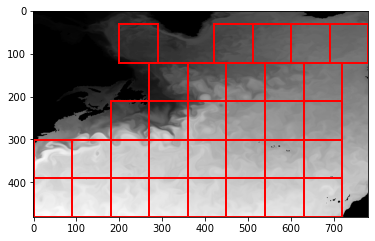

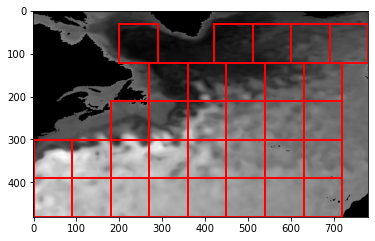

0 images processed
500 images processed
1000 images processed
1500 images processed
2000 images processed
2500 images processed
3000 images processed
3500 images processed


In [3]:
# sorted nc files pathes
nc_files = sorted(glob.glob(destDir + '/*.nc'))
# display the sst and ssh patches to crop
sst = loadNATL(nc_files[0], field="thetao")
ssh = loadNATL(nc_files[0], field="zos")
ROIs = computeROIs()
displayROIs(sst, ROIs)
displayROIs(ssh, ROIs)
# create patches
for i in range(len(nc_files)):
    createPatches(nc_files[i], field="thetao")
    createPatches(nc_files[i], field="zos")
    if i%500 == 0:
        print("{} images processed".format(i))